Check clipped-SSTM and clipped-SGD on BERT + CoLA task

In [1]:
from graph_plot_tools import *
from utils import *

In [2]:
# Unzip the dataset (if we haven't already)
!pip install wget
import wget
import os
print('Downloading dataset')
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')
  if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t',
                 header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
...,...,...,...,...
8546,ad03,0,*,Poseidon appears to own a dragon
8547,ad03,0,*,Digitize is my happiest memory
8548,ad03,1,NaN,It is easy to slay the Gorgon.
8549,ad03,1,NaN,I had the strangest feeling that I knew you.


In [4]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [5]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
# For every sentence...
for sent in df.sentence.values:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
# Print sentence 0, now as a list of IDs.
print('Original: ', df.sentence.values[0])
print('Token IDs:', input_ids[0])


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [6]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))


Max sentence length:  47


In [7]:
# from keras.preprocessing.sequence import pad_sequences
def pad_sequences(seqs, maxlen=None, value=0, padding="post"):
    if maxlen is None:
        raise ValueError("Invalid maxlen: {}".format(maxlen))
    for i in range(len(seqs)):
        add = [value] * max(0, maxlen - len(seqs[i]))
        if padding == "post":
            seqs[i] = seqs[i] + add
        elif padding == "pre":
            seqs[i] = add + seqs[i]
    return seqs

MAX_LEN =  max([len(sen) for sen in input_ids])+1
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, value=0, padding="post")
print('\Done.')


Padding/truncating all sentences to 48 values...

Padding token: "[PAD]", ID: 0
\Done.


In [8]:
# Create attention masks
attention_masks = []
# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

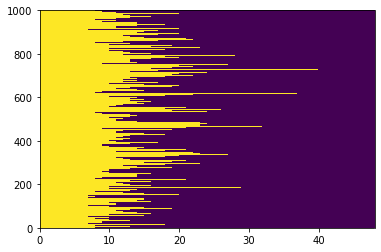

In [9]:
import matplotlib.pyplot as plt
plt.pcolor(attention_masks[1000:2000])

In [10]:
df.label.values

array([1, 1, 1, ..., 1, 1, 1])

### Dataset train/val splits

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

data_split_rs = 49


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,df.label.values, 
                                                            random_state=data_split_rs, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, df.label.values,
                                             random_state=data_split_rs, test_size=0.1)

In [12]:
import torch
import scipy.stats
import matplotlib.pyplot as plt
import tqdm
import numpy as np

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 SUPER


In [13]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
random_seed = 4
num_workers = 1

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
###full_grad_dataloader
batch_size = 32 # train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader_for_full_grad = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)


### for training
batch_size = 32 # train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
val_loader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)

### Tasks (models + optimizers)

In [15]:
import torch.nn as nn
import torch.optim as optim

from transformers import BertForSequenceClassification

from optimizers import clipped_SGD, clipped_SSTM

nets = []

history_random_seed = 74

for starting_point_random_seed in [73, 74]:
    for _ in range(4):
        # setting the same starting point for all algorithms
        torch.manual_seed(starting_point_random_seed)
        nets.append(
            BertForSequenceClassification.from_pretrained(
                "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                num_labels = 2, # The number of output labels--2 for binary classification.
                                # You can increase this for multi-class tasks.   
                output_attentions = False, # Whether the model returns attentions weights.
                output_hidden_states = False, # Whether the model returns all hidden-states.
            )
        )

        nets[-1].zero_grad()
        for i, name_param in enumerate(nets[-1].named_parameters()):
            if i < 197: # 197 -- 2 linears, 199 - only last linear
                name_param[1].requires_grad = False

        nets[-1].train()

# changing this one doesn't affect starting point, but changes training process (history)
torch.manual_seed(history_random_seed)


opts = []

for i in range(2):
    opts += [
        torch.optim.Adam(nets[i * 4 + 0].parameters(), lr = 5e-5, eps = 1e-8, weight_decay=0.0005),
        optim.SGD(nets[i * 4 + 1].parameters(), lr=0.001, momentum=0.9),
        clipped_SGD(nets[i * 4 + 2].parameters(), lr=2e-3, momentum=0.9, 
                    clipping_type="coordinate_wise", clipping_level=0.1),
        clipped_SSTM(nets[i * 4 + 3].parameters(), lr=0.08, L=10, 
                     clipping_type='norm', clipping_level=1, nu=1),  # with bs_mul = 8
#         clipped_SSTM(nets[i * 4 + 0].parameters(), lr=0.00125, L=10, 
#                      clipping_type='norm', clipping_level=1, nu=1),  # with bs_mul = 1
#         clipped_SSTM(nets[i * 4 + 1].parameters(), lr=0.005, L=10, 
#                      clipping_type='norm', clipping_level=1, nu=1),  # with bs_mul = 2
#         clipped_SSTM(nets[i * 4 + 2].parameters(), lr=0.02, L=10, 
#                      clipping_type='norm', clipping_level=1, nu=1),  # with bs_mul = 4
#         clipped_SSTM(nets[i * 4 + 3].parameters(), lr=0.08, L=10, 
#                      clipping_type='norm', clipping_level=1, nu=1),  # with bs_mul = 8
    ]

opt_names = [ # normal opts names
    "Adam, 5e-5, eps 1e-8, weight_decay 0.0005, bs_mul = 1",
    "SGD, 0.001, 0.9, bs_mul = 1",
    "clipped_SGD, 2e-3, 0.9, coordinate_wise, 0.1, bs_mul = 1",
    "clipped_SSTM, 0.08, 10, norm, 1, bs_mul = 8, nu=1",
#     "clipped_SSTM, 0.00125, 10, norm, 1, bs_mul = 1, nu=1",
#     "clipped_SSTM, 0.005, 10, norm, 1, bs_mul = 2, nu=1",
#     "clipped_SSTM, 0.02, 10, norm, 1, bs_mul = 4, nu=1",
#     "clipped_SSTM, 0.08, 10, norm, 1, bs_mul = 8, nu=1",
] * 2

bs_muls = [
    1, 1, 1, 8
#     1, 2, 4, 8
] * 2

lr_decays = [
    1, 1, 1, 1,
#     1, 1, 1, 1,
] * 2

hist = []

for (net, optimizer, opt_name, bs_mul, lr_decay) in zip(nets, opts, opt_names, bs_muls, lr_decays):
    hist.append({
        "task_name": "BERT on CoLA",
        "name": opt_name, 
        "bs_mul": bs_mul,
        "lr_decay": lr_decay,
        "train_loss": [], "train_x": [], 
        "val_loss": [], "val_x": [], 
        "train_acc_top_1": [], "train_acc_top_5": [], 
        "val_acc_top_1": [], "val_acc_top_5": [], 
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Norm diffs functions

In [16]:
import scipy
from scipy import stats
from tqdm.notebook import tqdm

def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss


def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

    print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad)) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)

    return fully_grad / (step * dataloader_for_full_grad.batch_size)


def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, repeats=1):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()

    print("Computing norm diffs")
    with tqdm(total=repeats * len(dataloader)) as pbar:
        for _ in range(repeats):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)

    return np.array(mini_norms)

In [17]:
from copy import deepcopy
import numpy as np

def get_loss(model, criterion, batch):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    outputs = model(
        b_input_ids, 
        token_type_ids=None, 
        attention_mask=b_input_mask, 
        labels=b_labels
    )

    loss=outputs[0]
    return loss

def recursive_to(param, device):
    # Not sure if there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            # Not sure there are any global tensors in the state dict
            recursive_to(param, device)

### Training

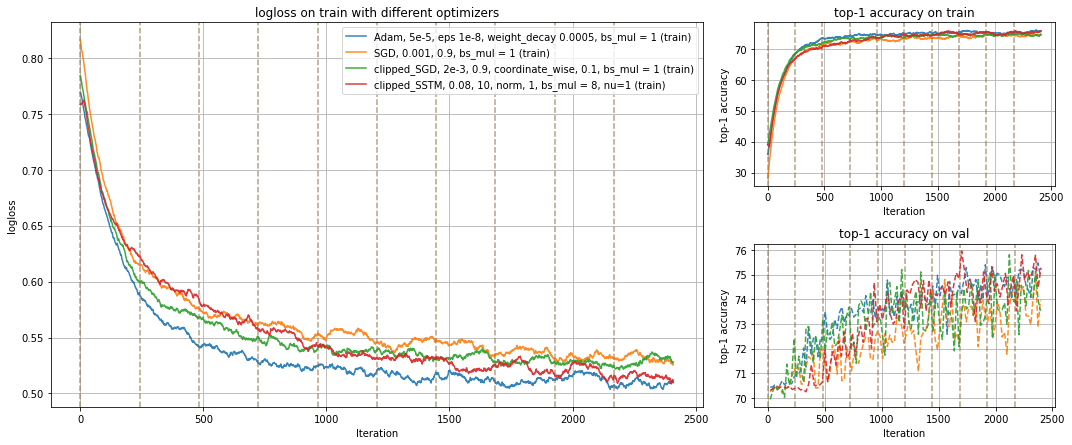

Finished Training


In [18]:
from IPython import display

batch_mul_step_count = 400
calc_norm_diffs = False


for epoch in range(10):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        net.to(device)
        optimizer_to(optimizer, device)

        total_steps = net_hist["total_steps"]
        # effective batch size will be batch_size * bs_mul
        bs_mul = net_hist["bs_mul"]
        # learning rate decay rate
        lr_decay = net_hist["lr_decay"]
            
        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]
            
        net_hist["epochs_x"].append(total_steps)

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # compute norm diffs distribution on train dataset
            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > 500 or len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer, None, 
                    train_loader_for_full_grad, train_loader, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False
            ######################################################################
            if lr_decay < 1:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            ######################################################################
            
            # train
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)

            outputs = net(
                inputs, 
                token_type_ids=None, 
                attention_mask=masks, 
                labels=labels
            )
            loss = outputs[0] / bs_mul
            loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer.step()
                optimizer.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1 
                    bs_mul = net_hist["bs_mul_value"]

            top_1 = accuracy(outputs.logits, labels.data, topk=(1,))
            net_hist["train_acc_top_1"].append(top_1[0].detach().cpu().item())

            # evaluate on validation dataset
            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > 20 and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_losses = []
                val_accs = []
                
                with torch.no_grad():
                    for step, val_data in enumerate(val_loader):

                        inputs, masks, labels = val_data[0].to(device), val_data[1].to(device), val_data[2].to(device)

                        outputs = net(
                            inputs, 
                            token_type_ids=None, 
                            attention_mask=masks, 
                            labels=labels
                        )
                        loss = outputs[0]

                        val_losses.append(loss.detach().cpu().item())

                        acc = accuracy(outputs.logits, labels.data, topk=(1,))
                        val_accs.append(acc[0].detach().cpu().item())

                net_hist["val_loss"].append(np.mean(val_losses))
                net_hist["val_x"].append(total_steps)

                net_hist["val_acc_top_1"].append(np.mean(val_accs))

                net.train()

            if total_steps % 100 == 0:
                display.clear_output(wait=True)
                
                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(ax1, grouped_hist, eps=0.01, make_val=False, alpha=0.9)
                ax2 = make_accuracy_plot(ax2, grouped_hist, eps=0.01, make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(ax3, grouped_hist, eps=0.01, make_train=False, make_val=True, top_k=1, alpha=0.9)
                
                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
        net.to("cpu")
        optimizer_to(optimizer, "cpu")

print('Finished Training')

### Save models / train data

In [21]:
from datetime import datetime

now = datetime.now()
now = str(now)

In [22]:
save_net_weights = False


if save_net_weights:
    for i in range(len(nets)):
        if "/" in hist[i]["name"]:
            hist[i]["name"] = ":".join(hist[i]["name"].split("/"))
        PATH = './models/bert_{}.pth'.format(
            "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":") + hist[i]["name"].split())
        )
        torch.save(nets[0].state_dict(), PATH)

In [23]:
from copy import deepcopy

hist3 = deepcopy(hist)

In [24]:
for h in hist3:
    for key in h:
        if isinstance(h[key], list) and  len(h[key])> 0 :
            if isinstance(h[key][0], torch.Tensor):
                for i in range(len(h[key])):
                    h[key][i] = h[key][i].numpy()
            if isinstance(h[key][0], np.ndarray):
                for i in range(len(h[key])):
                    if len(h[key][i]) == 1:
                        h[key][i] = np.asscalar(h[key][i])
                    else:
                        h[key][i] = [str(x) for x in h[key][i]]
            for i in range(len(h[key])):
                if not isinstance(h[key][i], list):
                    h[key][i] = str(h[key][i])

In [25]:
import json
with open('./models/bert_{}_train_hist.json'.format("_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")))
          , 'w') as fout:
    json.dump(hist3 , fout)

### Averaged plots

In [19]:
import json
hists_names_list = [
    "bert_train_hist_combined",
#     "bert_2021-05-28_02_25_51_train_hist", # bert, (47 (69,70)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-27_22_41_49_train_hist", # bert, (47 (67,68)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-27_18_52_41_train_hist", # bert, (46 (65,66)) (adam, sgd, clipped_sstm, clipped_sgd) + norm diffs
#     "bert_2021-05-16_10_19_28_train_hist", # bert, (46 (63,64)) (adam, sgd, clipped_sstm, clipped_sgd) + norm diffs
#     "bert_2021-05-15_11_43_51_train_hist", # bert, (45 (61,62)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-15_07_12_01_train_hist", # bert, (45 (59,60)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-14_21_16_07_train_hist", # bert, (44 (57,58)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-14_16_29_32_train_hist", # bert, (44 (55,56)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-14_11_17_17_train_hist", # bert, (43 (55,56)) (adam, sgd, clipped_sstm, clipped_sgd)
#     "bert_2021-05-27_11_18_29_train_hist", # bert, (43 (51,52)) (adam, sgd, clipped_sstm, clipped_sgd) + norm diffs
]


hist = hist_from_json(load_hist_jsons(hists_names_list))

In [20]:
grouped_hist = group_uniques_full(
    hist, 
    ["train_loss", "val_loss", "train_acc_top_1", "val_acc_top_1"], 
    verbose=True,
    group_norm_diffs=True
)

grouped_hist = grouped_hist[0:4]

def key(h, alpha=0.01):
    return smooth(h["train_loss"], alpha)[-1]

grouped_hist = sorted(grouped_hist, key=key)

Repeats_1 = 100.0, Name = Adam, 5e-5, eps 1e-8, weight_decay 0.0005, bs_mul = 1
Repeats_1 = 100.0, Name = SGD, 0.001, 0.9, bs_mul = 1
Repeats_1 = 100.0, Name = clipped_SSTM, 0.08, 10, norm, 1, bs_mul = 8, nu=1
Repeats_1 = 100.0, Name = clipped_SGD, 2e-3, 0.9, coordinate_wise, 0.1, bs_mul = 1


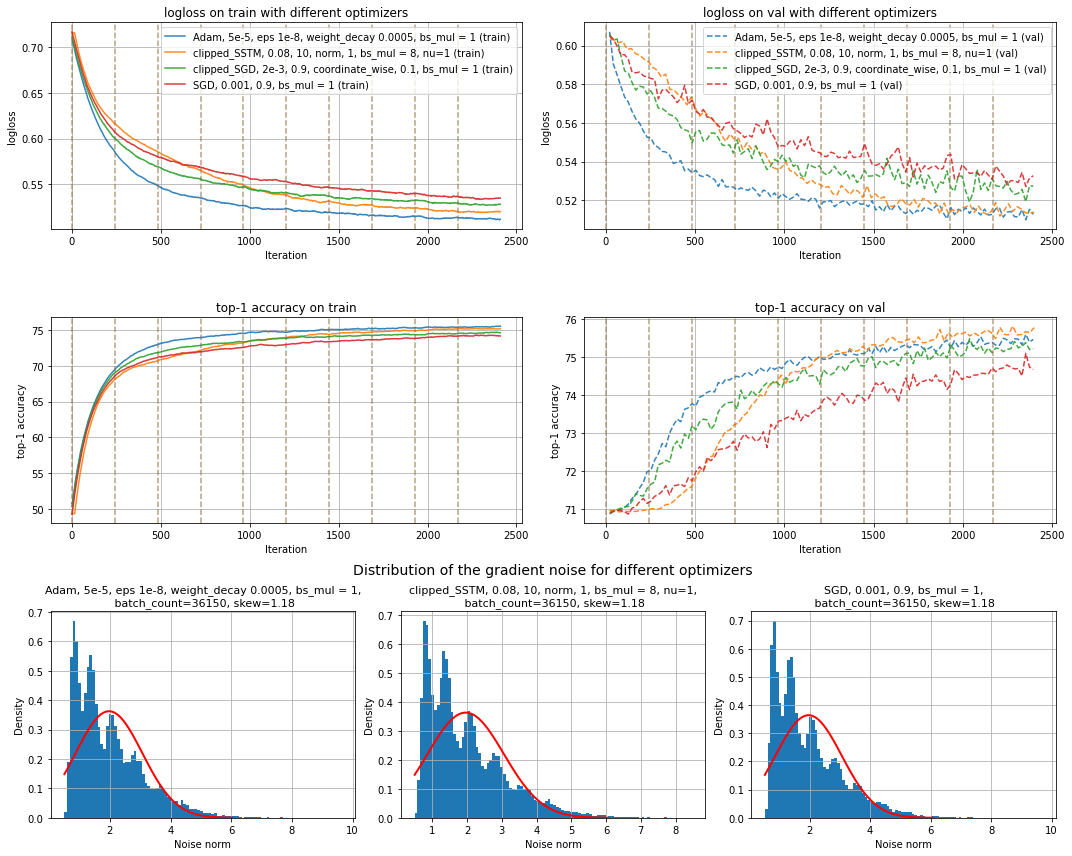

In [27]:
fig = plt.figure(figsize=(15,12))
gs = GridSpec(3,2, figure=fig)


display.clear_output(wait=True)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

ax1 = make_loss_plot(ax1, grouped_hist, eps=0.01, make_val=False, alpha=0.9)
ax2 = make_loss_plot(ax2, grouped_hist, eps=0.01, make_train=False, alpha=0.9)
ax3 = make_accuracy_plot(ax3, grouped_hist, eps=0.01, make_train=True, make_val=False, top_k=1, alpha=0.9)
ax4 = make_accuracy_plot(ax4, grouped_hist, eps=0.01, make_train=False, make_val=True, top_k=1, alpha=0.9)

grouped_hist_for_distrs = [grouped_hist[0], grouped_hist[1], grouped_hist[3]]

draw_norm_hists_for_different_models(fig, gs[2:,:], grouped_hist_for_distrs, bins_n=100, draw_normal=True, number=0)

gs.tight_layout(fig)
plt.draw()
plt.show()